**Title:** A classification model predicting knowledge status of users

**Introduction:**

We are using a User Knowledge Modelling dataset that classifies the students' knowledge of Electrical DC Machines.

We obtain our data from the UC Irvine Machine Learning Repository, from the User Knowledge Modeling Page. The data was donated from the article "The Development of intuitive knowledge classifier and the Modelling of domain-dependent data" (Kahraman, 2013).
It uses an intuitive knowledge classifier to create four classes: Very low (0-50), Low (122), Middle (129), and High (130). This data provides weighted differences for dependent data users in different domains to create a better user modelling system.

The article "Why study time does not predict grade point average across college students: Implications of deliberate practice for academic performance" (Plant, 2004), identifies that study time is not an effective variable on its own to predict a student's academic performance. The most important aspect of study time is how effective the study time is. Plant discussed the importance of "deliberate practice," the most important part of studying. We assume that the STG, the study time of object goal materials, variable reports the effective studying of the target materials.

Kang writes in his article that scheduled review and practice with spaced intervals can improve the efficiency of learning (Kang, 2016). We chose the variable SCG, which measures the degree of repetition since spaced-out repetition shows improvement in the learning capabilities of students.

Madeleine also states that "If you are unsure about the difference between your grades and your personal knowledge in a subject, I challenge you to reflect on your grades and ask yourself if you feel your grade is reflective of your knowledge of the subject or if there are discrepancies between the two (Madeleine, 2021)." Using PEG as a predictor will provide a more compelling narrative of how our predictions relate to our targets.

Question: Can we use STG, SCG and PEG as input values to build a good enough classification model 
that can predict the knowledge level of future users?


There are five attributes in our dataset:
1. the degree of study time for goal object materials (STG), 
2. the degree of repetition number of user for goal object materials (SCG), 
3. the degree of study time of user for related objects with goal object (STR), 
4. the exam performance of user for related objects with goal object (LPR), 
5. the exam performance of user for goal objects (PEG).

Among the five attributes, we decide to use STG, SCG and PEG as predictors because they are directly related to the goal object materials. 

**Methods and General steps for data analysis (This is an outline. More details are provided in code comments)**

Preliminary exploratory data analysis:

1. Load the dataset.

2. Clean and wrangle the dataset into tidy format.

3. Split the data into training and test sets.

4. Perform an exploratory summary of the dataset.

5. Create an exploratory visualization of the dataset


Main data analysis: 

6. Define the target value: UNS.

7. Select the variables: STG, SCG, PEG.

8. Split the data into training and test sets.

9. Cross-validation using the vfold_cv function.

10. Create a recipe.

11. Build the k-nearest model with neighbours  = tune() 

12. Create a workflow(), and use the tune_grid function to estimate the classifier accuracy for a range of K values.

13. Plot neighbours vs accuracy estimate to find the best K value.

14. Use the best K to make a new model specification and retrain the classifier.

15. Evaluate the accuracy on the test set.

16. Visualize our results

**Preliminary exploratory data analysis:**

In [1]:
# libraries used
set.seed(2000)

library(tidyverse)
library("readxl")
library(tidymodels)
     

## load the file
# this demonstrates that the dataset can be read from the web into R 

url <- "https://archive.ics.uci.edu/static/public/257/user+knowledge+modeling.zip"
download.file(url, "user_data.zip")
unzip("user_data.zip")
user_data_old <- read_excel("Data_User_Modeling_Dataset_Hamdi Tolga KAHRAMAN.xls",sheet=2)
head(user_data_old)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

STG,SCG,STR,LPR,PEG,UNS,...7,...8,Attribute Information:
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>,<lgl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low,NA,NA,"STG (The degree of study time for goal object materails),"
0.08,0.08,0.10,0.24,0.90,High,NA,NA,SCG (The degree of repetition number of user for goal object materails)
0.06,0.06,0.05,0.25,0.33,Low,NA,NA,STR (The degree of study time of user for related objects with goal object)
0.10,0.10,0.15,0.65,0.30,Middle,NA,NA,LPR (The exam performance of user for related objects with goal object)
0.08,0.08,0.08,0.98,0.24,Low,NA,NA,PEG (The exam performance of user for goal objects)
0.09,0.15,0.40,0.10,0.66,Middle,NA,NA,UNS (The knowledge level of user)


                                                Table 1.1

In [2]:
# create the users df, which contains all the useful columns only

users <- user_data_old |> select(STG:UNS) |> mutate(UNS = as_factor(UNS))
head(users)


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low
0.09,0.15,0.40,0.10,0.66,Middle


              Table 2.1

**This data is in tidy format:**

A tidy data frame satisfies the following three criteria:
1. Each row is a single observation.
2. Each column is a single variable.
3. Each value is in a single cell.

Our dataset meets the above criteria.

In [3]:
# Split the data into training and test sets

user_split <- initial_split(users, prop = 0.75, strata = UNS)
user_train <- training(user_split)
user_test <- testing(user_split) 

In [4]:
# The number of observations in each class in the training set
# We make sure there is no extreme class imbalance (see 5.7.2 in textbook).

n_class <- user_train |> group_by(UNS)|> summarize(count=n())
n_class

UNS,count
<fct>,<int>
very_low,19
High,46
Low,62
Middle,65


   Table 4.1

In [5]:
# The means and standard deviations of the predictor variables
# Since there are no NAs in these summarize tables, 
# It also means there are no NAs in the dataset

# Furthermore, since both means and standard deviations of predictors are on comparable scales,
# we do not have to do any centering or scaling.

means <- user_train |> summarize(across(c(STG,SCG,PEG), mean))
means

sds <- user_train |> summarize(across(c(STG,SCG,PEG), sd))
sds

STG,SCG,PEG
<dbl>,<dbl>,<dbl>
0.3544271,0.3627135,0.4548437


STG,SCG,PEG
<dbl>,<dbl>,<dbl>
0.2038692,0.2172399,0.2567701


   Table 4.2 and Table 4.3

In [6]:
# put all 3 predictors into one column to be able to compare subplots containing their distributions

user_train_wide <- user_train |> select(STG, SCG, PEG) |>
                pivot_longer(cols=c(STG,SCG,PEG),names_to="predictors",values_to="values")
head(user_train_wide)


predictors,values
<chr>,<dbl>
STG,0.00
SCG,0.00
PEG,0.00
STG,0.08
SCG,0.08
PEG,0.90


Table 5.1

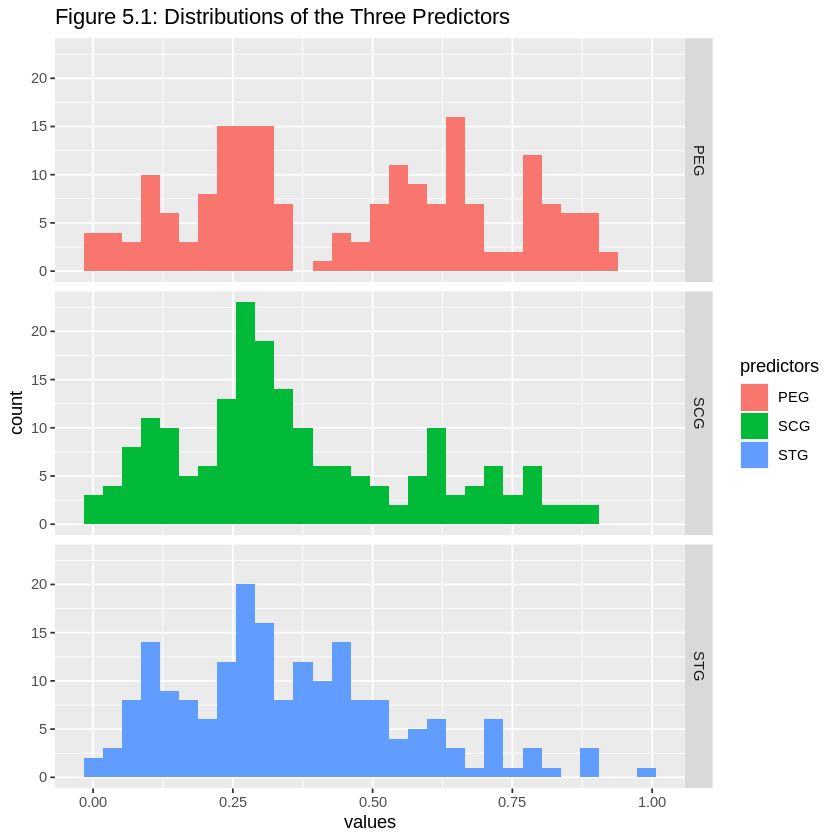

In [7]:
# Distributions of the three predictors 
dist_pred <- user_train_wide |> ggplot(aes(x=values, fill=predictors))+
                                geom_histogram(bins=30)+
                                facet_grid(rows=vars(predictors))+
                                ggtitle("Figure 5.1: Distributions of the Three Predictors")
dist_pred

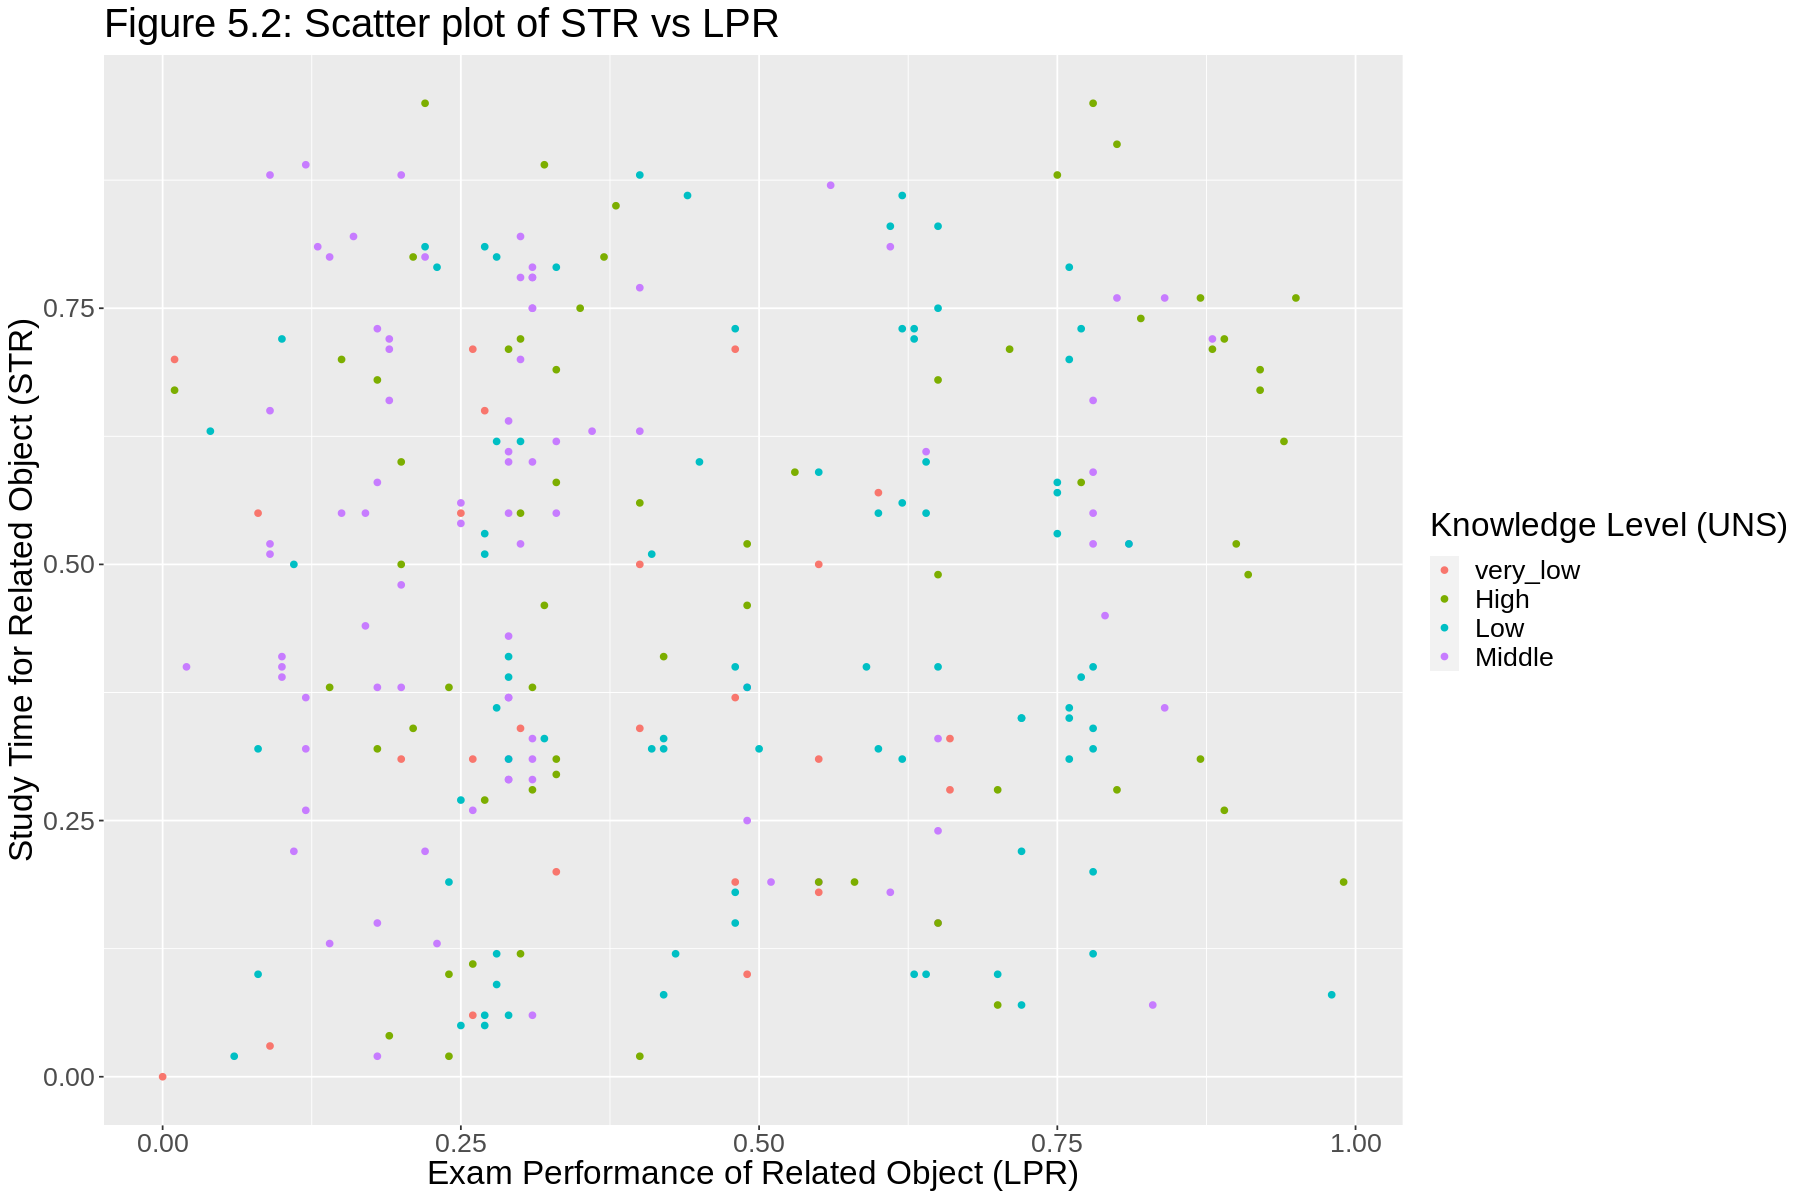

In [8]:
# Scatter plot of STR vs LPR to see if the two variables that we exclude from our predictors
# have some power to predict UNS.
# It seems that they don't have much power to predict UNS,
# which may indicate our decision of excluding these two variables from predictors is correct.

library(repr)
options(repr.plot.width=15, repr.plot.height=10)
rel_point <- users |> ggplot(aes(x=LPR,y=STR,colour=UNS))+
                        geom_point()+
                        labs(x="Exam Performance of Related Object (LPR)", 
                             y="Study Time for Related Object (STR)",
                            colour="Knowledge Level (UNS)")+
                        theme(text=element_text(size=20))+
                        ggtitle("Figure 5.2: Scatter plot of STR vs LPR")
rel_point

**Main Data Analysis**

In [9]:
# Select only the columns we need

user <- users |> select(STG, SCG, PEG, UNS)
head(user)

STG,SCG,PEG,UNS
<dbl>,<dbl>,<dbl>,<fct>
0.00,0.00,0.00,very_low
0.08,0.08,0.90,High
0.06,0.06,0.33,Low
0.10,0.10,0.30,Middle
0.08,0.08,0.24,Low
0.09,0.15,0.66,Middle


Table 7.1

In [10]:
# Split into training and testing sets

user_split <- initial_split(user, prop = 0.75, strata = UNS)
user_train <- training(user_split)
user_test <- testing(user_split) 

In [11]:
# Create 5-fold

user_vfold <- vfold_cv(user_train, v = 5, strata = UNS)

In [12]:
# Build a recipe using training data

user_recipe <- recipe(UNS ~ ., data = user_train) |>
                step_scale(all_predictors()) |>
                step_center(all_predictors())

In [13]:
# Build a k-nn classification model with neighbors = tune()

knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

In [14]:
# Tune the model and select the best K

k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

knn_results <- workflow() |>
  add_recipe(user_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = user_vfold, grid = k_vals) |>
  collect_metrics() 


In [15]:
# Tune the model and select the best K

accuracies <- knn_results |>
  filter(.metric == "accuracy")

accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.7321033,5,0.02483295,Preprocessor1_Model01
2,accuracy,multiclass,0.7321033,5,0.02483295,Preprocessor1_Model02
3,accuracy,multiclass,0.7416979,5,0.01478116,Preprocessor1_Model03
4,accuracy,multiclass,0.7416979,5,0.01478116,Preprocessor1_Model04
5,accuracy,multiclass,0.7314207,5,0.01748908,Preprocessor1_Model05
6,accuracy,multiclass,0.7419543,5,0.01934315,Preprocessor1_Model06
7,accuracy,multiclass,0.7477651,5,0.03060309,Preprocessor1_Model07
8,accuracy,multiclass,0.7681705,5,0.02629241,Preprocessor1_Model08
9,accuracy,multiclass,0.7626369,5,0.01953046,Preprocessor1_Model09


Table 12.1

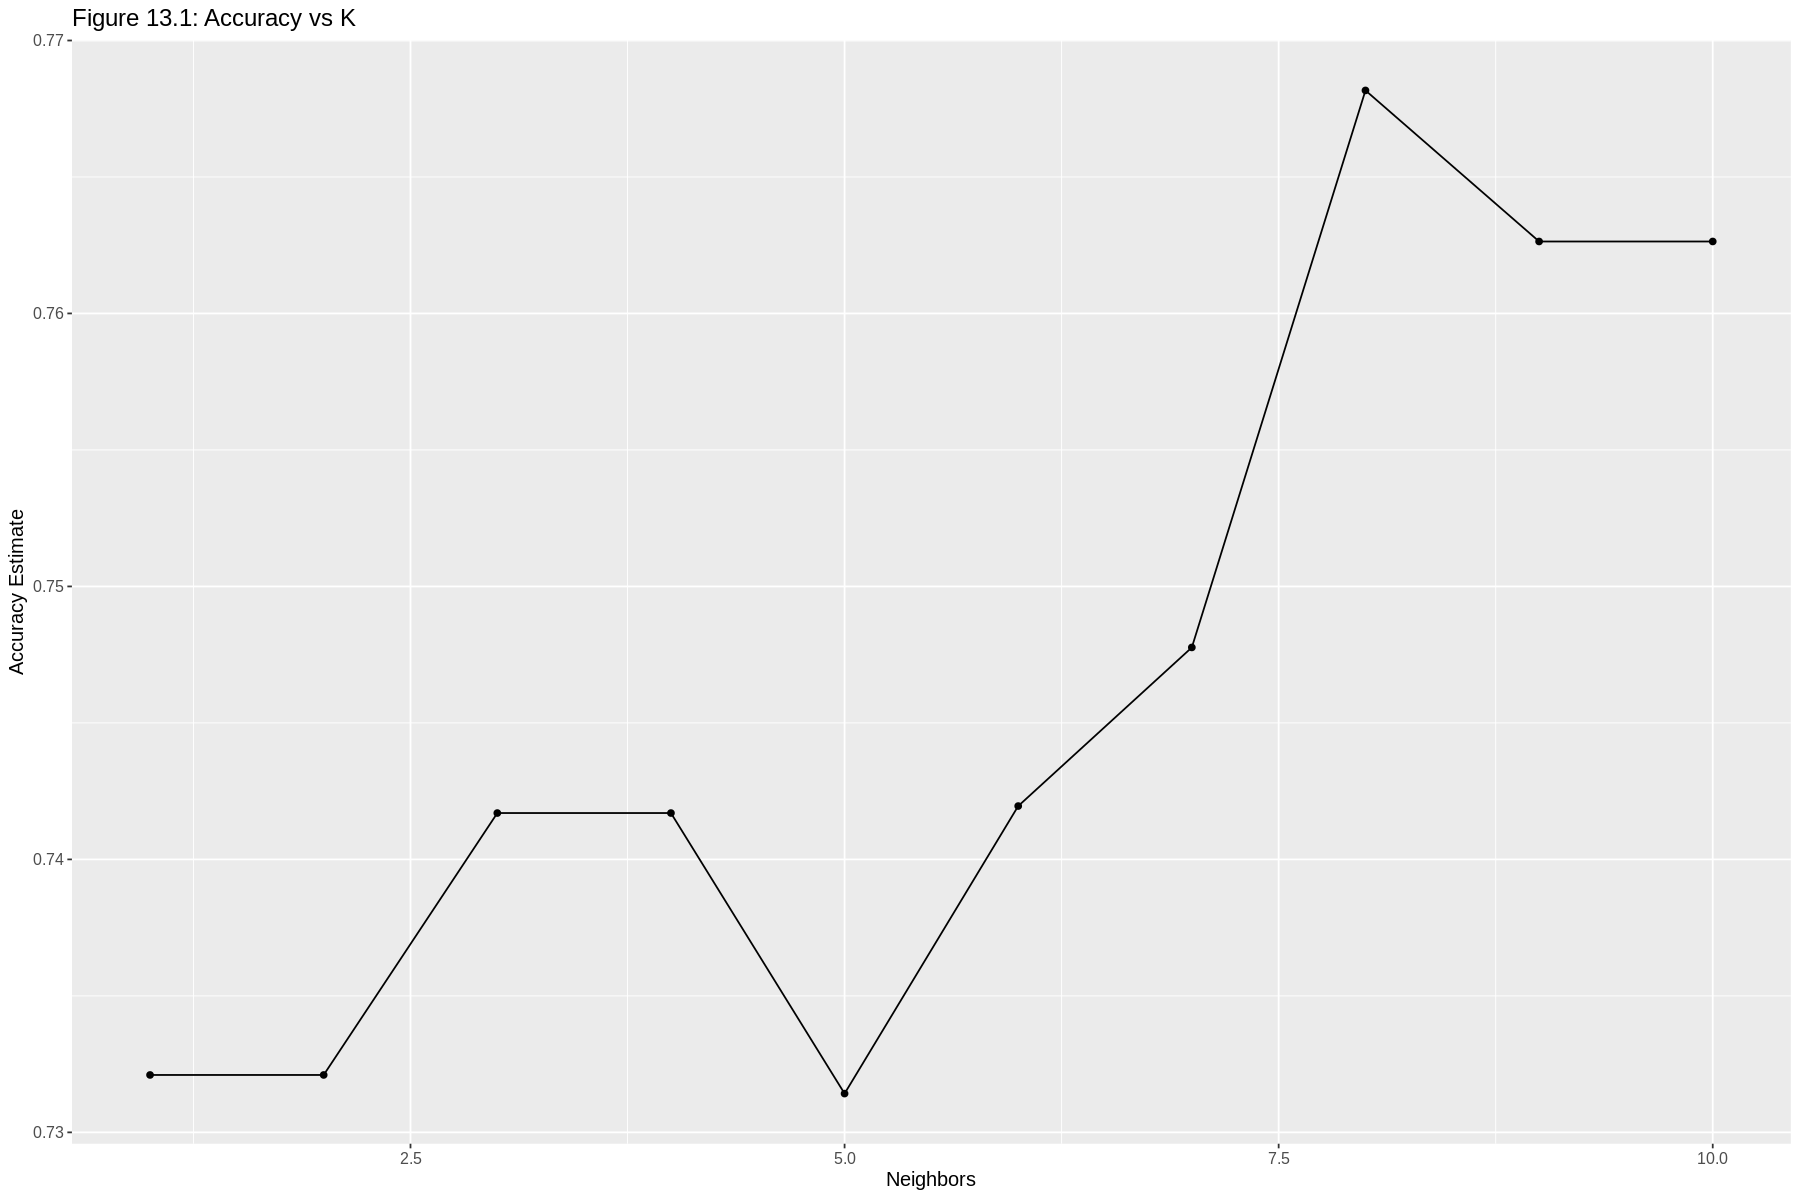

In [16]:
# Draw a plot of accuracy vs K

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12))+
  ggtitle("Figure 13.1: Accuracy vs K")

accuracy_vs_k

In [17]:
# Pick the best K. If there are multiple Ks to pick, pick the smallest one to reduce computing power needed

best_k <- accuracies|> filter(mean == max(mean)) |>
                        select(neighbors)|>
                        filter(neighbors == min(neighbors))|>
                        pull()


In [18]:
# Retrain a model using the best k

knn_spec_new <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

In [19]:
# Create a new workflow using the new model

knn_fit <- workflow() |>
  add_recipe(user_recipe) |>
  add_model(knn_spec_new) |>
  fit(data = user_train)

knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(8,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.253886
Best kernel: rectangular
Best k: 8

In [20]:
# Predict UNS on the testing data

user_test_predictions <- predict(knn_fit, user_test) |>
  bind_cols(user_test)

head(user_test_predictions)

.pred_class,STG,SCG,PEG,UNS
<fct>,<dbl>,<dbl>,<dbl>,<fct>
High,0.08,0.08,0.90,High
Low,0.06,0.06,0.33,Low
Middle,0.09,0.15,0.66,Middle
Low,0.20,0.14,0.25,Low
Low,0.06,0.29,0.25,Low
High,0.20,0.45,0.78,High


Table 15.1

In [21]:
# Check accuracy of our predictions

user_test_predictions |>
  metrics(truth = UNS, estimate = .pred_class)|>
    filter(.metric == "accuracy")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.8461538


Table 15.2

In [22]:
# Confusion matrix of our predictions

confusion <- user_test_predictions |>
             conf_mat(truth = UNS, estimate = .pred_class)
confusion

          Truth
Prediction very_low High Low Middle
  very_low        2    0   0      0
  High            0   14   0      2
  Low             3    0  21      4
  Middle          0    1   0     18

Table 15.3

**Visualization of the results:**

We decide to compare the true classification of testing data with the predicted classification of testing data to visualize the accuracy of our model.

Since we use three predictors to predict Knowledge Level, there is no way to directly visualize our results using 2-D graphs. Hence, the only way we can do is to combine the three predictors two-by-two (3 kinds of combinations in total) to indirectly check the accuracy.
As long as the original graphs and the prediction graphs look similar, we should be confident that our model is good.

In [23]:
# Codes to create visualizations

library(cowplot)
options(repr.plot.width = 15, repr.plot.height = 7)
# STG vs PEG
STG_PEG_original <- user_test_predictions |>
                    ggplot(aes(x=PEG, y=STG, color=UNS))+
                    geom_point(size=5)+
                    ggtitle("Figure 16.1: STG vs PEG, Original")+
                    labs(x="Exam Performance of user for Goal Objects (PEG)",
                         y = "Study Time for Goal Object Materials (STG)",
                         color = "Knowledge Level")+
                    theme(text=element_text(size=15))
STG_PEG_prediction <- user_test_predictions |>
                    ggplot(aes(x=PEG, y=STG, color=.pred_class))+
                    geom_point(size=5)+
                     ggtitle("Figure 16.2: STG vs PEG, Predictions")+
                    labs(x="Exam Performance of user for Goal Objects (PEG)",
                         y = "Study Time for Goal Object Materials (STG)",
                         color = "Predictions")+
                    theme(text=element_text(size=15))

STG_SCG_original <- user_test_predictions |>
                    ggplot(aes(x=SCG, y=STG, color=UNS))+
                    geom_point(size=5)+
                    ggtitle("Figure 16.3: STG vs SCG, Original")+
                    labs(x="Repetition number of users for Goal Object Materials (SCG)",
                         y = "Study Time for Goal Object Materials (STG)",
                         color = "Knowledge Level")+
                    theme(text=element_text(size=15))
STG_SCG_prediction <- user_test_predictions |>
                    ggplot(aes(x=SCG, y=STG, color=.pred_class))+
                    geom_point(size=5)+
                     ggtitle("Figure 16.4: STG vs SCG, Predictions")+
                    labs(x="Repetition number of users for Goal Object Materials (SCG)",
                         y = "Study Time for Goal Object Materials (STG)",
                         color = "Predictions")+
                    theme(text=element_text(size=15))

SCG_PEG_original <- user_test_predictions |>
                    ggplot(aes(x=PEG, y=SCG, color=UNS))+
                    geom_point(size=5)+
                    ggtitle("Figure 16.5: SCG vs PEG, Original")+
                    labs(x="Exam Performance of user for Goal Objects (PEG)",
                         y = "Repetition number of users for Goal Object Materials (SCG)",
                         color = "Knowledge Level")+
                    theme(text=element_text(size=15))
SCG_PEG_prediction <- user_test_predictions |>
                    ggplot(aes(x=PEG, y=SCG, color=.pred_class))+
                    geom_point(size=5)+
                     ggtitle("Figure 16.6: SCG vs PEG, Predictions")+
                    labs(x="Exam Performance of user for Goal Objects (PEG)",
                         y = "Repetition number of users for Goal Object Materials (SCG)",
                         color = "Predictions")+
                    theme(text=element_text(size=15))

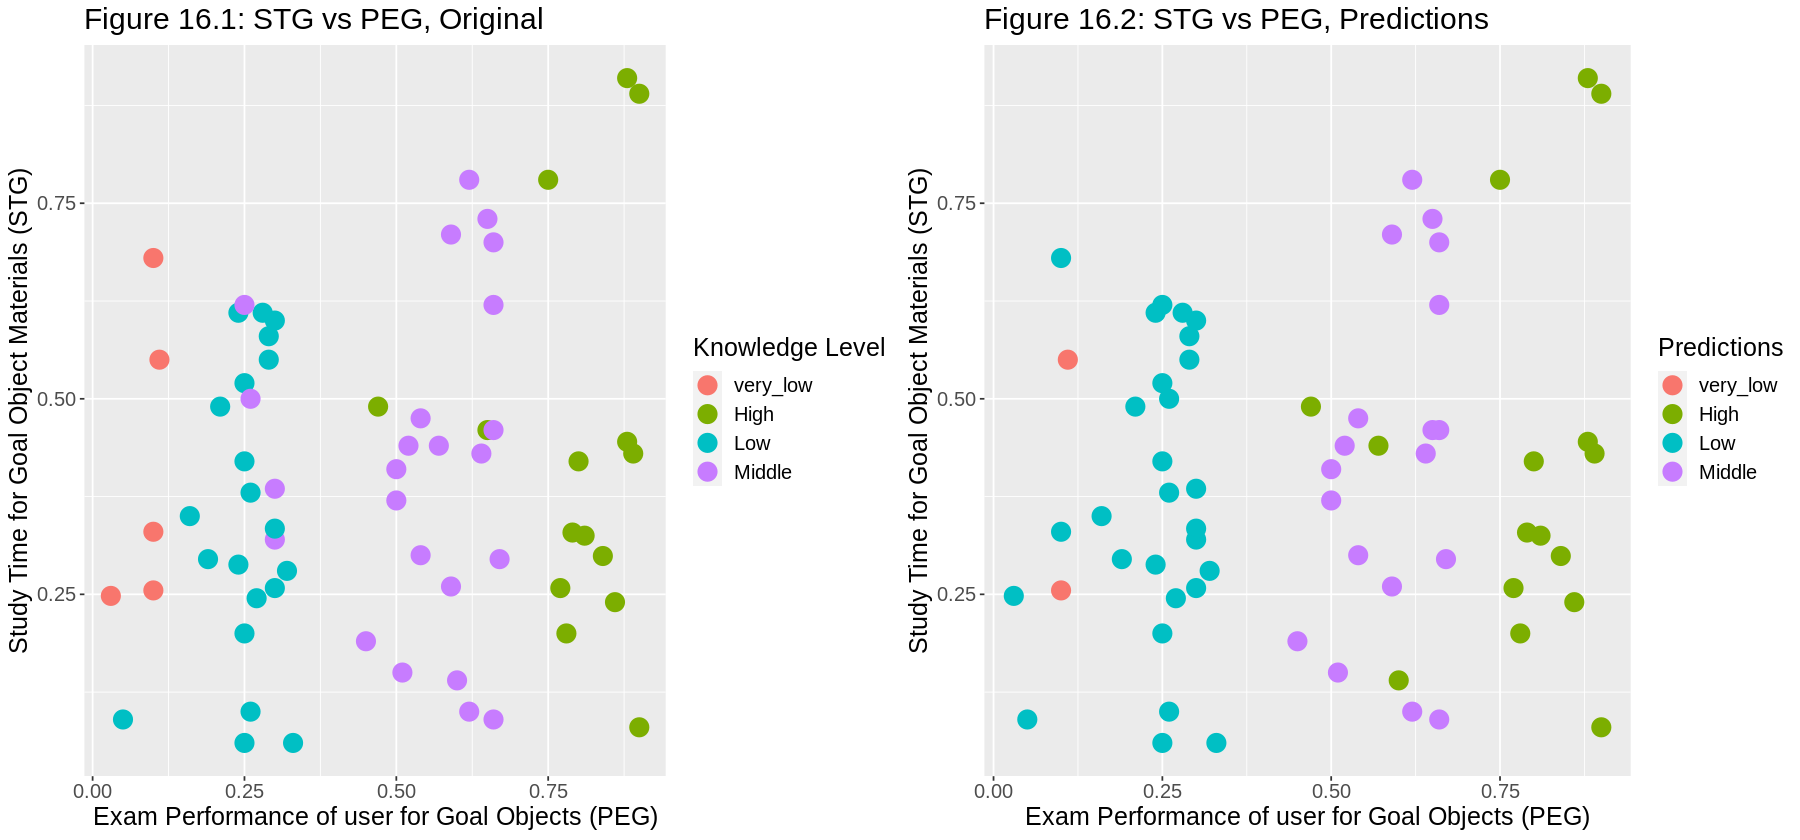

In [24]:
# STG vs PEG
plot_grid(STG_PEG_original, STG_PEG_prediction, ncol = 2)

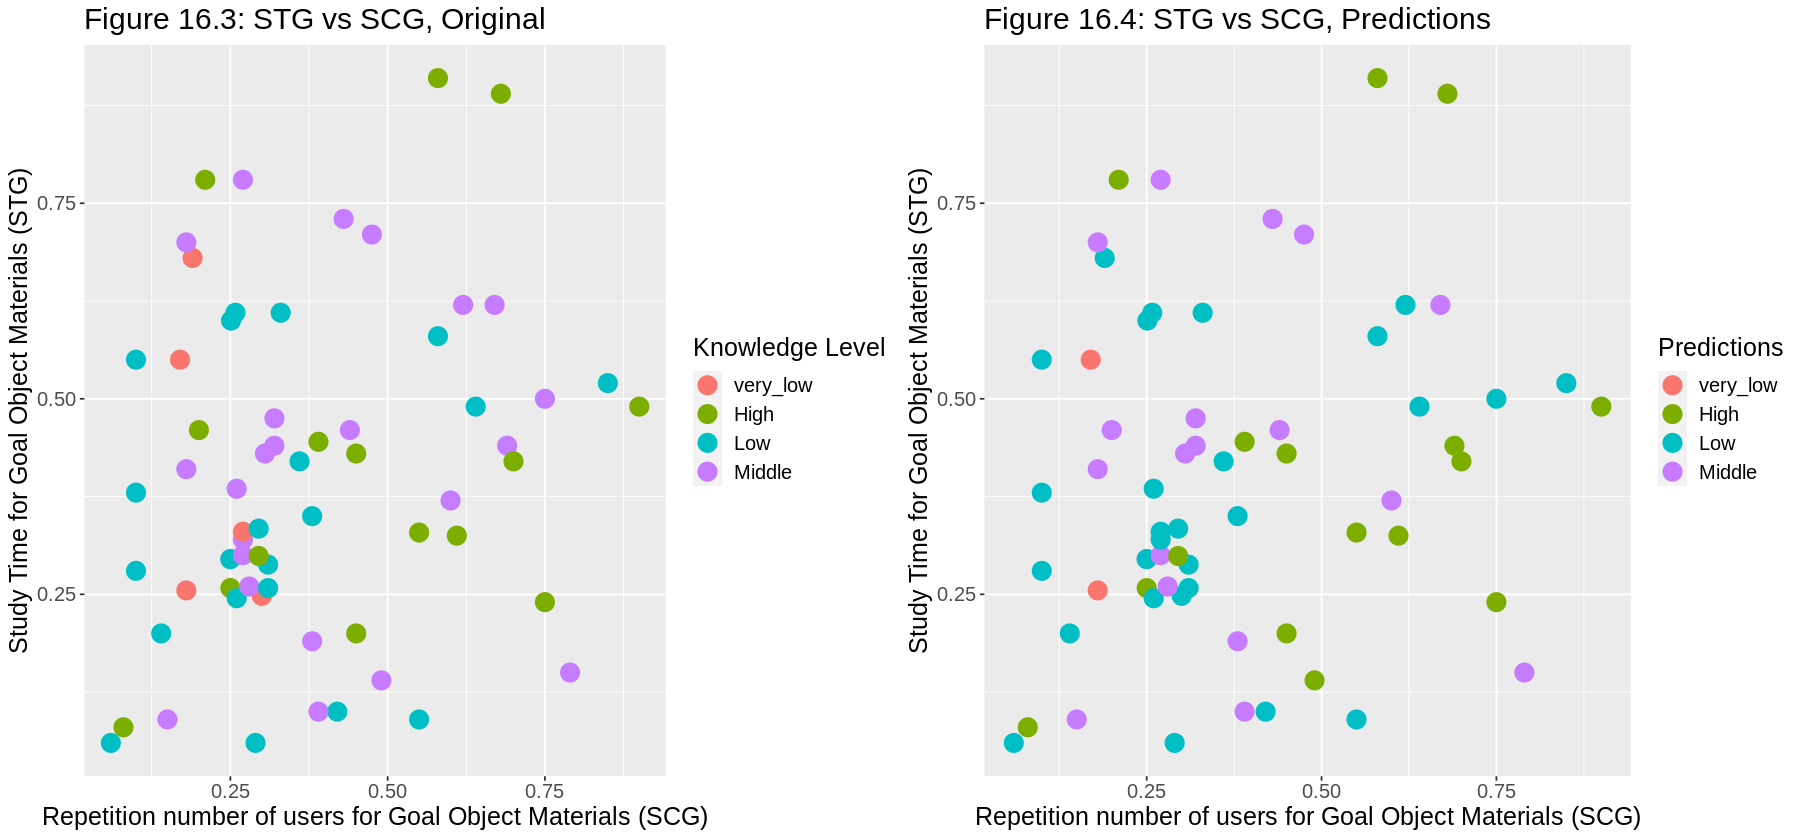

In [25]:
# STG vs SCG
plot_grid(STG_SCG_original, STG_SCG_prediction, ncol = 2)

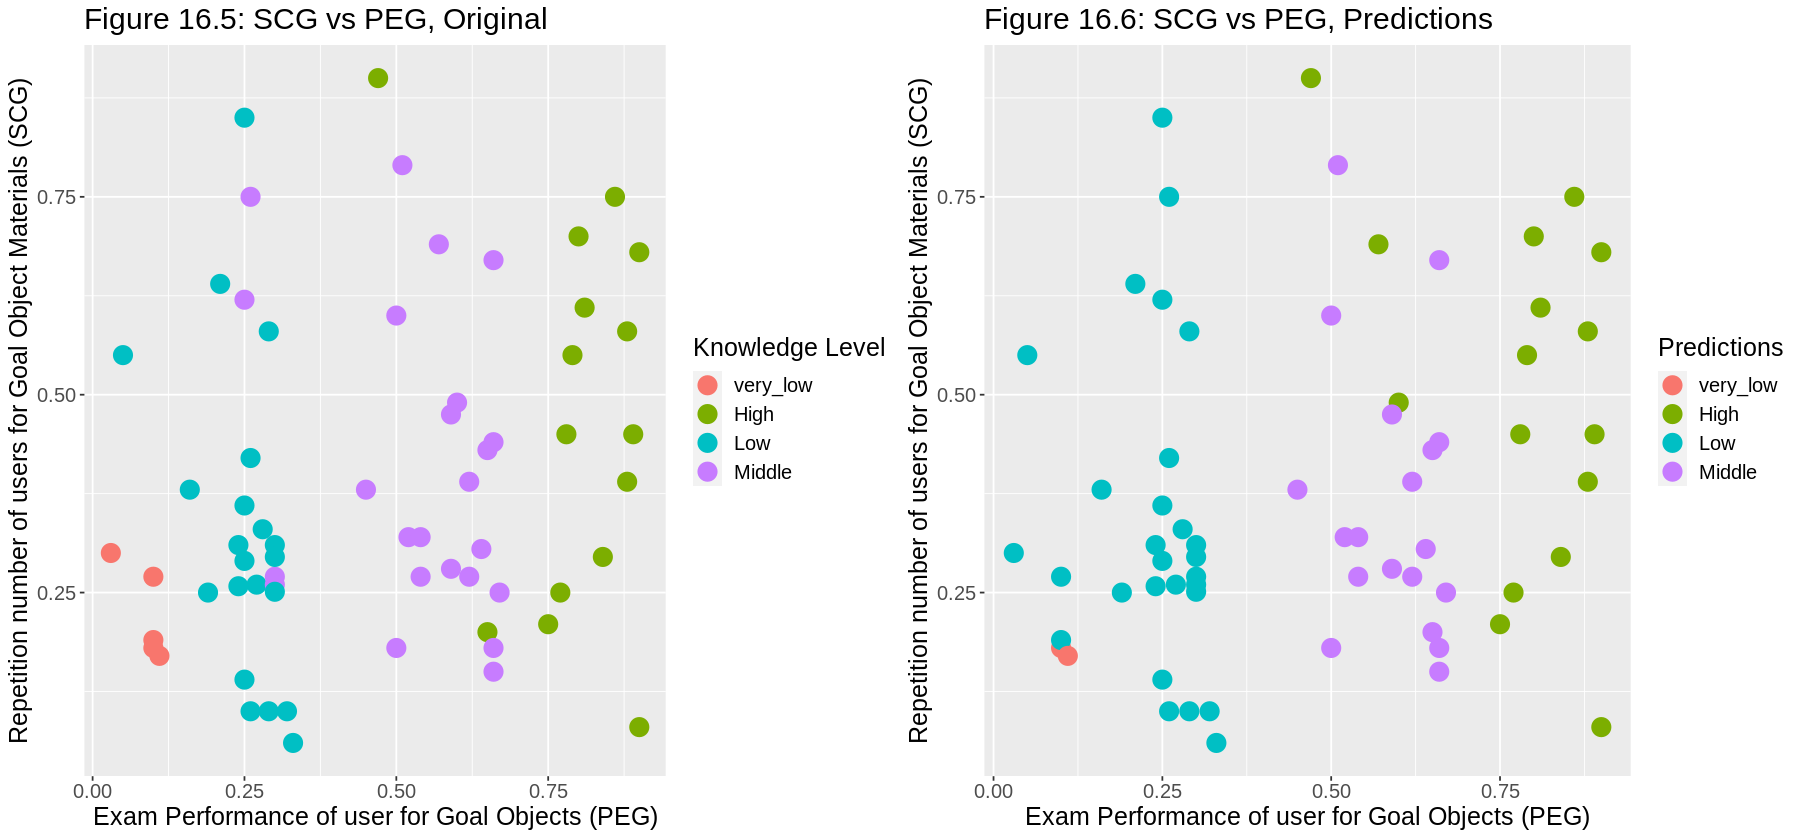

In [26]:
# SCG vs PEG
plot_grid(SCG_PEG_original, SCG_PEG_prediction, ncol = 2)

**Discussions:**

1. Summarize what you found

We found that STG (study time for goal object materials), SCG (repetition number of user for goal object materials ) and PEG (the exam performance of user for goal objects) can perdict the UNS (the knowledge level of users) of a new student with pretty good accuracy. Specifically, in our analysis, the prediction accuracy can be as high as 0.84 using knn-classification model with K = 8.

2. Whether this is what you expected to find

Yes, this is the same as what we expected in our proposal. 

3. What impact could such findings have?

Our findings can help employ people. For example, if the people a company needs require some understanding of certain materials, we can evaluate their knowledge level by surveying their study time for the materials, repetition frequencies for the materials and their related exam performances.
Our findings can also help students assess the efficiencies of their study strategies and their ability to comprehend the subject.

4. What future questions could this lead to?

Can more variables such as the method of studying and students’ self evaluation of preparedness increase the accuracy of the classification model?
If we reduce one variable, can we get similar or same results?



**References:**